# Trend Convexity

This notebook will focus on the background research within the Trend following paper. This paper shows that historically hedge funds generate strategies that are negatively convex to the market returns while on the other hand trend following returns are positively convex. 

Diego Alvarez <br> diego.alvarez@colorado.edu

# Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

# Path Management

In [2]:
parent_path  = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path    = os.path.join(parent_path, "data")
src_path     = os.path.join(parent_path, "src")
hf_path      = os.path.join(data_path, "hf_indices.parquet")
spx_path     = os.path.join(data_path, "spx.parquet")
futures_path = os.path.join(data_path, "futures.parquet")

renamer = {
    "BARCBTOP": "Barclay CTA",
    "HFRIFWI" : "Hedge Fund Composite Index",
    "NEIXCTA" : "SocGen CTA Index"}

# Background Data

In [3]:
df_hf_raw = (pd.read_parquet(
    path = hf_path, engine = "pyarrow").
    assign(security = lambda x: x.security.str.split(" ").str[0]))

df_hf_rtn = (df_hf_raw.rename(
    columns = {"security": ""}).
    pivot(index = "date", columns = "", values = "PX_LAST").
    ffill().
    dropna().
    pct_change())

df_spx = (pd.read_parquet(
    path = spx_path, engine = "pyarrow").
    query("security == 'SPX Index'").
    assign(security = lambda x: x.security.str.split(" ").str[0]).
    rename(columns = {"PX_LAST": "SPX"}).
    drop(columns = ["security"]).
    set_index("date"))

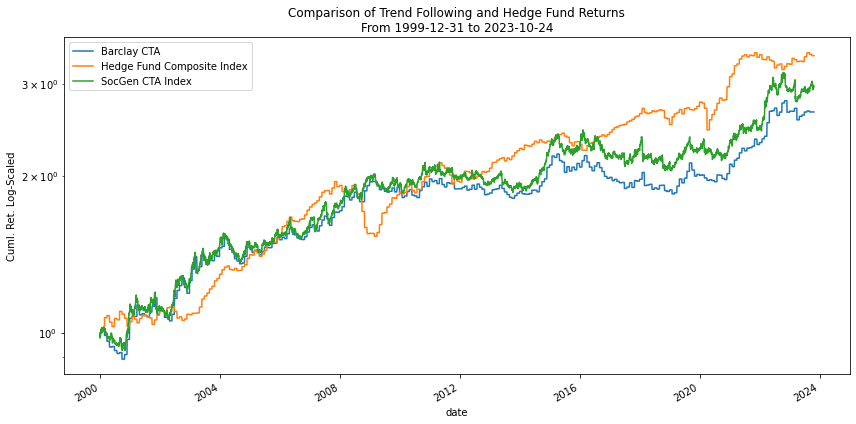

In [4]:
(df_hf_rtn.apply(
    lambda x: np.cumprod(1 + x)).
    rename(columns = renamer).
    plot(
        figsize = (12,6),
        logy    = True,
        ylabel  = "Cuml. Ret. Log-Scaled",
        title   = "Comparison of Trend Following and Hedge Fund Returns\nFrom {} to {}".format(
            df_hf_rtn.index.min().date(),
            df_hf_rtn.index.max().date())))

plt.tight_layout()

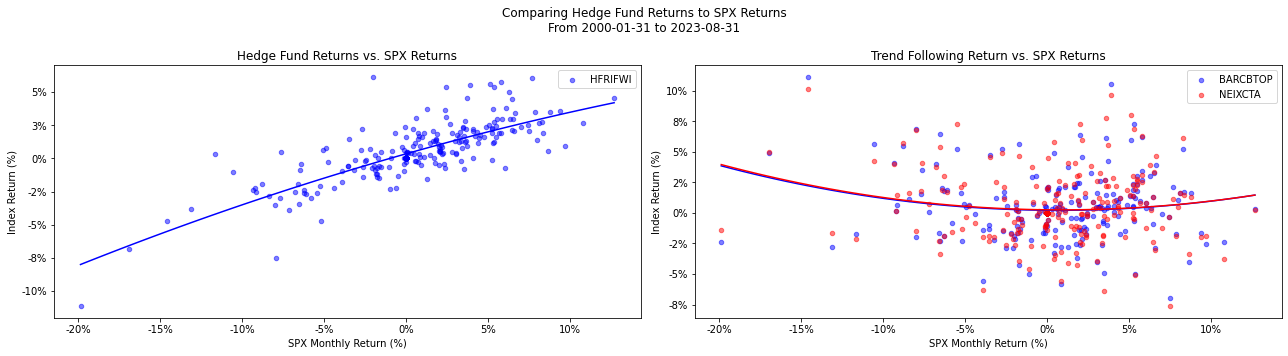

In [5]:
df_longer = (df_hf_raw.pivot(
    index = "date", columns = "security", values = "PX_LAST").
    merge(right = df_spx, how = "inner", on = ["date"]).
    dropna().
    resample("1M").
    last().
    pct_change().
    reset_index().
    melt(id_vars = ["date", "SPX"]).
    dropna())

ax_mapper = {
    "BARCBTOP": 1,
    "HFRIFWI" : 0,
    "NEIXCTA" : 1}

color_mapper = {
    "BARCBTOP": "blue",
    "HFRIFWI" : "blue",
    "NEIXCTA" : "red"}

fig, axes = plt.subplots(ncols = 2, figsize = (18,5))
for key in ax_mapper.keys():
    
    df_tmp_plot = (df_longer.query(
        "variable == @key"))
    
    poly_model = (np.poly1d(np.polyfit(
        x   = df_tmp_plot.SPX,
        y   = df_tmp_plot.value,
        deg = 2)))
    
    x = np.linspace(
        start = df_tmp_plot.SPX.min(),
        stop  = df_tmp_plot.SPX.max())
    
    y = poly_model(x)
    
    (df_tmp_plot.
        plot(
            ax     = axes[ax_mapper[key]],
            kind   = "scatter", 
            x      = "SPX",
            y      = "value",
            color  = color_mapper[key],
            style  = "o",
            alpha  = 0.5,
            label  = key,
            xlabel = "SPX Monthly Return (%)",
            ylabel = "Index Return (%)"))
    
    axes[ax_mapper[key]].plot(x, y, color = color_mapper[key])
    
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
    
axes[0].set_title("Hedge Fund Returns vs. SPX Returns")
axes[1].set_title("Trend Following Return vs. SPX Returns")

fig.suptitle("Comparing Hedge Fund Returns to SPX Returns\nFrom {} to {}".format(
    df_longer.date.min().date(),
    df_longer.date.max().date()))

plt.tight_layout()

Above is a model showing the relationship between the index return and SPX returns. Hedge Fund returns are negatively convex to SPX returns, while Trend Following returns are positively convex to SPX. This implies that trend following returns can help investors generate a positive convexity to the market. 

In [6]:
def _get_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    model = (sm.OLS(
        endog = df.value,
        exog  = sm.add_constant(df.SPX)).
        fit())
    
    df_out = (pd.DataFrame({
        "param_val": model.params,
        "p_value"  : model.pvalues,
        "t_stat"   : model.tvalues}))
    
    return df_out

Below is a regression of hedge fund returns against SPX squared returns. The positive values for the SPX**2 component is statistically significant. 

In [7]:
(df_hf_raw.pivot(
    index = "date", columns = "security", values = "PX_LAST").
    merge(right = df_spx, how = "inner", on = ["date"]).
    resample("1M").
    last().
    pct_change().
    assign(SPX = lambda x: x.SPX ** 2).
    reset_index().
    melt(id_vars = ["date", "SPX"]).
    set_index("date").
    dropna().
    groupby("variable").
    apply(_get_ols).
    apply(lambda x: np.round(x,4)))

param_val  p_value  t_stat
variable                                  
BARCBTOP const     0.0034   0.0121  2.5204
         SPX       1.2213   0.0000  5.1679
HFRIFWI  const     0.0088   0.0000  7.0612
         SPX      -0.6717   0.0402 -2.0587
NEIXCTA  const     0.0030   0.0901  1.7007
         SPX       0.5652   0.2292  1.2050

Below is a regression of hedge fund returns against SPX. Hedge fund returns have a 0.35 beta to market returns. It's difficult to make a fair assessment because within the Trend Following space trend followers primarily futures, swaps, and other highly liquid ETFs and are asset class agnostic. On the other hand hedge fund returns are difficult to dissect. This is because most of the hedge fund strategies are equity driven so there is a larger tilt. It's also assumed that most hedge funds keep a market neutral approach while that is not usually achieved. With that being said most of the performance analysis is benchmarked against SPX so it will be the index used. 

In [8]:
(df_longer.set_index(
    "date").
    groupby("variable").
    apply(_get_ols).
    apply(lambda x: np.round(x,4))
    [["param_val", "t_stat", "p_value"]])

param_val   t_stat  p_value
variable                                   
BARCBTOP const     0.0039   2.7914   0.0056
         SPX      -0.0364  -1.1398   0.2553
HFRIFWI  const     0.0028   3.6961   0.0003
         SPX       0.3592  20.8785   0.0000
NEIXCTA  const     0.0043   2.8454   0.0048
         SPX      -0.0395  -1.1491   0.2515

When controlling for both trend following returns achieve both small beta exposure to SPX 

In [9]:
def _get_two_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    model = (sm.OLS(
        endog = df.value,
        exog  = sm.add_constant(df[["SPX", "SPX2"]])).
        fit())
    
    df_out = (pd.DataFrame({
        "param_val": model.params,
        "p_value"  : model.pvalues,
        "t_stat"   : model.tvalues}))
    
    return df_out

(df_hf_raw.pivot(
    index = "date", columns = "security", values = "PX_LAST").
    merge(right = df_spx, how = "inner", on = ["date"]).
    resample("1M").
    last().
    pct_change().
    assign(SPX2 = lambda x: x.SPX ** 2).
    reset_index().
    melt(id_vars = ["date", "SPX", "SPX2"]).
    dropna().
    set_index("date").
    groupby("variable").
    apply(_get_two_ols).
    apply(lambda x: np.round(x,4)))

param_val  p_value   t_stat
variable                                   
BARCBTOP const     0.0033   0.0163   2.4116
         SPX       0.0075   0.7873   0.2699
         SPX2      1.2300   0.0000   5.1518
HFRIFWI  const     0.0064   0.0000   6.3429
         SPX       0.3039   0.0000  15.2435
         SPX2     -0.5659   0.0302  -2.1756
NEIXCTA  const     0.0035   0.0477   1.9890
         SPX      -0.0592   0.0819  -1.7458
         SPX2      0.4290   0.3660   0.9055